In [1]:
#accessing netcdf files from Hector's folders
import os, glob, sys
sys.path.append("//nobackup//amondal//Python//Hector_Python_Scripts")
sys.path.append("//nobackup/amondal//Python//mit_geos_analysis")
#from mds_store import openmdsdataset
#playing with netcdf - xarray
import numpy as np
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
# How about visualization?
%matplotlib inline
import xrft
import netCDF4
import xgcm
from netCDF4 import Dataset
#from xmitgcm import open_mdsdataset
from GetNCDataSet import getMITNCDataSet
from MIT_xr_cwt_dateloc_fol import loadMITData
from MITllc2160Depth import *



from dask.distributed import Client
client = Client(memory_limit='90GB',n_workers = 40, threads_per_worker=1)

In [2]:
sys.path.append("//nobackup/amondal//Python//xmitgcm//xmitgcm")
from xmitgcm.mds_store import open_mdsdataset


So in this notebook, we're hoping to wrap up an idea of where to integrate vertically to calculate mixed layer temperature variance budget. I'll be trying to do a few things at the same time - 1. I'm going to do a sensitivity study of the budget balance as a function of integration depth and 2. I'm going to look at frequency wavenumber spectra for theta at various depths

In [3]:
%time depthToZlayer(200)

CPU times: user 19.1 ms, sys: 5.91 ms, total: 25 ms
Wall time: 123 ms


28

In [4]:
zlayerToDepth(30)

251.76999999999998

So we should download 40 layers and do the sum to layer 40 and 38 and compare for the first few months

In [3]:
%time hbl = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'KPPhbl', 0,0 )

Time combined dataset has been opened.
I concatenated the first Z-layer
CPU times: user 53 s, sys: 6.52 s, total: 59.5 s
Wall time: 2min 7s


In [4]:
hblc = hbl.compute()

In [5]:
def coarseGrainHbl_MAX(hblset):
    periodlength = 24
    periodnum = int(hblset.dims['time'] / periodlength)
    hblsel = hblset['KPPhbl']
    perioddepths = np.empty(periodnum)
    hblcoarsegrain = np.empty(0)
    for index in range(0,periodnum):
        perioddepths[index] = hblsel[index*periodlength:(index+1)*periodlength].max(dim='time').values
        hblcoarsegrain = np.concatenate((hblcoarsegrain, np.full(periodlength, perioddepths[index])),casting='same_kind')
    hMax = xr.DataArray(data = hblcoarsegrain, dims = hblsel.dims, coords = hblsel.coords)
    return hMax

In [6]:
%matplotlib inline
hblcm = hblc.max(dim=['lat','lon'])

In [7]:
hblcmcg = coarseGrainHbl_MAX(hblcm)

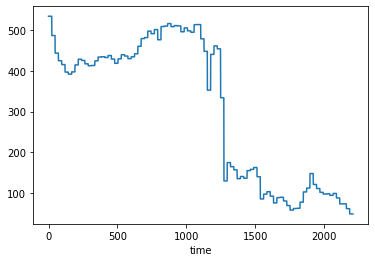

In [8]:
%matplotlib inline
hblcmcg.plot()

In [14]:
xr.where(np.abs(hblcmcg.diff('time') - 88.024) < 0.05, 1,0).data

array([0, 0, 0, ..., 0, 0, 0])

In [5]:
SST = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'Theta', 0,0 )

Time combined dataset has been opened.
I concatenated the first Z-layer


In [9]:
SSTc = SST.compute()
SSTc

<xarray.Dataset>
Dimensions:  (lat: 300, lon: 625, time: 2208)
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -65.0 -64.96 -64.92 -64.88 ... -40.12 -40.08 -40.04
Dimensions without coordinates: time
Data variables:
    Theta    (time, lat, lon) float64 20.43 20.42 20.43 ... 15.25 15.26 15.09

In [11]:
SSTcs = SSTc.sel(lon = slice(-60.04, -45) )

I'm going to start by calculating spectra of SST just for the exercise - I should be able to see some kind of frequency peaks here.

In [12]:
SSTw = SSTcs.sel(time=slice(0,1200)) #splitting the variable into the winter and summer regimes
SSTs = SSTcs.sel(time=slice(1300,-1))

In [13]:
SSTs

<xarray.Dataset>
Dimensions:  (lat: 300, lon: 376, time: 907)
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -60.04 -60.0 -59.96 -59.92 ... -45.12 -45.08 -45.04
Dimensions without coordinates: time
Data variables:
    Theta    (time, lat, lon) float64 21.73 21.76 21.76 ... 15.95 16.15 16.23

Spectra and Sums

Sums: I'm going to have to revisit and ideally parallelize all my code for this. That means going back to notebook 14 and doing xarray stuff
1. Figure out the most efficient way to add all these layers accurately.

Spectra: What's the procedure
1. Scale variables to what you want earlier (so days instead of hours for example, km instead of lat lon)
2. Detrend in space and time (fit to trend like Brian says)
3. Window - you'll have to play with xrft to get this part working, especially for normalizing the thing
4. FFT
5. Correctly deal with frequencies 
6. Normalize - the dx normalization is handled by doing true_amplitude
7. Normalize by window
8. Check Parseval's theorem  - do this before making it isotropic
9. Isotropize
10. Plot and add plot labels

In [87]:
T22= getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'Theta', 22,22 ).compute()
T22.nbytes / 1000000000

Time combined dataset has been opened.
I concatenated the first Z-layer


1.992504608

In [98]:
T22

<xarray.Dataset>
Dimensions:  (lat: 300, lon: 376, time: 2208)
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -60.04 -60.0 -59.96 -59.92 ... -45.12 -45.08 -45.04
Dimensions without coordinates: time
Data variables:
    Theta    (time, lat, lon) float64 20.1 20.04 20.04 ... 14.39 14.36 14.36

In [88]:
T39= getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'Theta', 39,39).compute()
T39.nbytes / 1000000000

Time combined dataset has been opened.
I concatenated the first Z-layer


5.304509608

In [104]:
Theta = SSTc.sel(lon = slice(-60.04, -45))
Theta

<xarray.Dataset>
Dimensions:  (lat: 300, lon: 376, time: 2208)
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -60.04 -60.0 -59.96 -59.92 ... -45.12 -45.08 -45.04
Dimensions without coordinates: time
Data variables:
    Theta    (time, lat, lon) float64 20.07 20.01 20.01 ... 15.91 16.11 16.2

In [2]:
Theta_A = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'Theta', 0,21)
Theta_B = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'Theta', 23,24)
Theta_C = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'Theta', 34,38)
     

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been 

In [3]:
Theta_D = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'Theta', 22,22)
Theta_E = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'Theta', 25,33)


Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer


distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home6/amondal/.conda/envs/xmitgcm3/lib/python3.8/site-packages/distributed/core.py", line 494, in handle_comm
    result = handler(comm, **msg)
  File "/home6/amondal/.conda/envs/xmitgcm3/lib/python3.8/site-packages/distributed/scheduler.py", line 3862, in heartbeat_worker
    ws._executing = {
  File "/home6/amondal/.conda/envs/xmitgcm3/lib/python3.8/site-packages/distributed/scheduler.py", line 3863, in <dictcomp>
    parent._tasks[key]: duration for key, duration in executing.items()
KeyError: 'open_dataset-26db38cd-39eb-4364-915e-154fca47b22e'
distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home6/amondal/.conda/envs/xmitgcm3/lib/python3.8/site-packages/distributed/core.py", line 494, in handle_comm
    result = handler(comm, **msg)
  File "/home6/amondal/.conda/envs/xmitgcm3/lib/python3.8/site-package

OSError: [Errno -101] NetCDF: HDF error: b'/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/Theta_41/Theta_2020041916.nc'

In [38]:
Theta_F = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'Theta', 39,40)
Theta_Fc = Theta_F.Theta.sel(lon = slice(-60, -45))

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer


In [29]:
Theta_Ac = Theta_A.Theta.sel(lon = slice(-60, -45.0))
Theta_Bc = Theta_B.Theta.sel(lon = slice(-60, -45.0))
Theta_Cc = Theta_C.Theta.sel(lon = slice(-60, -45.0))
Theta_Dc = Theta_D.Theta.sel(lon = slice(-60, -45))
Theta_Ec = Theta_E.Theta.sel(lon = slice(-60, -45))


In [78]:
Theta_Dc = Theta_Dc.interp(lon = Theta_Ac.lon, method = 'linear')
Theta_Bc = Theta_Bc.interp(lon = Theta_Ac.lon, method = 'linear')
Theta_Cc = Theta_Cc.interp(lon = Theta_Ac.lon, method = 'linear')
Theta_Ec = Theta_Ec.interp(lon = Theta_Ac.lon, method = 'linear')
Theta_Fc = Theta_Fc.interp(lon = Theta_Ac.lon, method = 'linear')


In [80]:
Thetac = xr.concat([Theta_Ac, Theta_Dc, Theta_Bc, Theta_Cc, Theta_Ec, Theta_Fc], dim = 'Zlayers', compat = "identical")

In [82]:
Thetac

,Array,Chunk
Bytes,75.88 GiB,878.91 kiB
Shape,"(41, 2208, 300, 375)","(1, 1, 300, 375)"
Count,1280677 Tasks,90528 Chunks
Type,float64,numpy.ndarray


In [47]:
Theta_Dc.dims == Theta_Ac.dims

False

In [12]:
HAdv_A = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'HAdv',0,21 )
HAdv_B = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'HAdv',23,24 )
HAdv_C = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'HAdv',34, 38 )



Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been 

In [20]:
HAdv_D = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'HAdv',22,22 )
HAdv_E = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'HAdv', 25,33 )
HAdv_F = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'HAdv',39,41 )

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer


In [31]:
HAdv_Ac = HAdv_A.HAdv.sel(lon = slice(-60, -45.0))
HAdv_Bc = HAdv_B.HAdv.sel(lon = slice(-60, -45.0))
HAdv_Cc = HAdv_C.HAdv.sel(lon = slice(-60, -45.0))
HAdv_Dc = HAdv_D.HAdv.sel(lon = slice(-60, -45))
HAdv_Ec = HAdv_E.HAdv.sel(lon = slice(-60, -45))
HAdv_Fc = HAdv_F.HAdv.sel(lon = slice(-60, -45))

In [84]:
HAdv_Dc = HAdv_Dc.interp(lon = HAdv_Ac.lon, method = 'linear')
HAdv_Bc = HAdv_Bc.interp(lon = HAdv_Ac.lon, method = 'linear')
HAdv_Cc = HAdv_Cc.interp(lon = HAdv_Ac.lon, method = 'linear')
HAdv_Ec = HAdv_Ec.interp(lon = HAdv_Ac.lon, method = 'linear')
HAdv_Fc = HAdv_Fc.interp(lon = HAdv_Ac.lon, method = 'linear')

In [85]:
HAdvc = xr.concat([HAdv_Ac, HAdv_Dc, HAdv_Bc, HAdv_Cc, HAdv_Ec, HAdv_Fc], dim = 'Zlayers', compat = "identical")

In [91]:
Thetac

,Array,Chunk
Bytes,75.88 GiB,878.91 kiB
Shape,"(41, 2208, 300, 375)","(1, 1, 300, 375)"
Count,1280677 Tasks,90528 Chunks
Type,float64,numpy.ndarray


In [94]:
T_summer = Thetac[:,1300:,:,:]
H_summer = HAdvc[1:,1300:,:,:] 

In [96]:
T_savg = getZlayerThickness(0)*T_summer.isel(Zlayers=0)
H_savg = getZlayerThickness(0)*H_summer.isel(Zlayers=0)
summer_depth_layer = 29
for index in range(1,summer_depth_layer):
    layerthick = getZlayerThickness(0+index)
    T_savg += layerthick*T_summer.isel(Zlayers=index)
    H_savg += layerthick*H_summer.isel(Zlayers=index)
    

In [98]:
H_savg

<xarray.DataArray 'HAdv' (time: 908, lat: 300, lon: 375)>
dask.array<add, shape=(908, 300, 375), dtype=float64, chunksize=(1, 300, 375), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -60.0 -59.96 -59.92 -59.88 ... -45.12 -45.08 -45.04
Dimensions without coordinates: time

In [99]:
Zeta

NameError: name 'Zeta' is not defined

In [100]:
T_s_29 = T_savg 
H_s_29 = H_savg

In [102]:
#T_s_32.to_netcdf('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/T_summer_sum25to32.nc4')
%time H_s_29.to_netcdf('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/H_summer_sum0to29.nc4')

CPU times: user 3min 49s, sys: 18.5 s, total: 4min 7s
Wall time: 6min 30s


In [103]:
%time T_s_29.to_netcdf('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/T_summer_sum0to29.nc4')

CPU times: user 3min 14s, sys: 16.5 s, total: 3min 30s
Wall time: 5min 23s


In [104]:
%%time
Zeta = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'Zeta',0,0 )
Q = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'oceQnet',0,0 )

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer
CPU times: user 43 s, sys: 6.1 s, total: 49.1 s
Wall time: 1min 52s


I DELETED ALL THESE ZETA AND Q FILES BECAUSE THEY DID NOT MATCH THE COORDINATES WE WANTED. SO IN THE MEANWHILE, YOU SHOULD TEST OUT LOADMITDATASET THAT MIGHT BE QUICKER!

In [107]:
Z = Zeta.Zeta[1300:, :, 1:]
Qn = Q.oceQnet[1300:, :,1:]

In [106]:
Zeta

<xarray.DataArray 'Zeta' (time: 0, lat: 300, lon: 376)>
dask.array<getitem, shape=(0, 300, 376), dtype=float64, chunksize=(0, 300, 376), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -60.04 -60.0 -59.96 -59.92 ... -45.12 -45.08 -45.04
Dimensions without coordinates: time

In [108]:
rhoConst = 1027.5 #kg/m^3
Cp = 1*(10**3) # J / (kg K)

In [109]:
Height = zlayerToDepth(summer_depth_layer)

In [133]:
Z = Z.interp(lon = T_s_29.lon, method = 'linear')
Qn = Qn.interp(lon = T_s_29.lon, method = 'linear')
H_s_29 = H_s_29.interp(lon = T_s_29.lon, method = 'linear')

In [136]:
ekman29 = Z*T_s_29 / (Height) #the second height here is to add the correct factor to the summed T, which should have been averaged
heatflux29 = Qn / ( rhoConst * Cp)

In [137]:
tendency_estimate_29 = ekman29+heatflux29-H_s_29 

In [115]:
tendency_29 = T_s_29.diff('time') / 3600

In [138]:
error29 = ((tendency_estimate_29[1:] - tendency_29)/tendency_29).sum()

In [121]:
t29c = tendency_29.compute()
te29c = tendency_estimate_29.compute()

In [125]:
ek29c = ekman29.compute()
hf29c = heatflux29.compute()
hadvc29 = H_s_29.compute()

In [ ]:
evak29 = error29.compute()

In [ ]:
evak29.values

In [ ]:
T_s_30 = T_s_29 + getZlayerThickness(30)*T_summer.isel(30)
ekman30 = Z*T_s_30 / (getZlayerThickness(30))
H_s_30 = H_S_29 + getZlayerThickness(30)*H_summer.isel(30)
tendency_estimate_30 = ekman30+heatflux29-H_s_30
tendency_30 = T_s_30.diff('time')/3600
error30 = ((tendency_estimate_30[1:] - tendency_30)/tendency_30).sum().compute()

## te30 = te32

In [59]:
te30 

<xarray.DataArray (time: 907, lat: 300, lon: 375)>
array([[[ 1.85824539e-07,  1.85824539e-07,  8.34474372e-07, ...,
          6.60694023e-07,  5.76206963e-07,  8.58249049e-07],
        [ 2.69759829e-07,  2.69759829e-07,  6.36427517e-07, ...,
          7.49599273e-07,  8.88305782e-07,  1.42194025e-06],
        [ 3.38107195e-07,  3.38107195e-07,  3.44600572e-07, ...,
          7.96252478e-07,  9.99037231e-07,  8.58220204e-07],
        ...,
        [ 6.73352413e-07,  6.73352413e-07, -9.68982150e-08, ...,
          2.56957632e-07,  6.21642155e-07, -6.34124526e-07],
        [-2.27752029e-07, -2.27752029e-07,  4.09101961e-07, ...,
          2.14828652e-06,  9.74186173e-07, -7.25774293e-07],
        [ 6.83961276e-07,  6.83961276e-07,  1.36633197e-06, ...,
          1.79013665e-06, -1.53327936e-07, -2.51965431e-07]],

       [[ 2.38792024e-07,  2.38792024e-07,  1.01384245e-06, ...,
          4.57086670e-07,  3.69915734e-07,  4.63603615e-07],
        [ 2.27031413e-07,  2.27031413e-07,  5.34356052e-07, ...,
          7.11192427e-07,  8.55746205e-07,  1.80749552e-06],
        [ 2.44599625e-07,  2.44599625e-07,  7.97561851e-08, ...,
          1.04501523e-06,  1.71503174e-06,  2.34428345e-06],
...
        [-1.00748882e-06, -1.00748882e-06, -6.33116418e-07, ...,
         -6.82283655e-07, -6.75077829e-07, -6.47973683e-07],
        [-8.94317298e-07, -8.94317298e-07, -2.83158944e-07, ...,
         -7.82385155e-07, -6.59678498e-07, -6.01723774e-07],
        [-7.96713699e-07, -7.96713699e-07, -5.72161522e-08, ...,
         -8.37995183e-07, -7.48694283e-07, -5.99860429e-07]],

       [[ 5.90175630e-08,  5.90175630e-08,  1.48778099e-07, ...,
          1.34213625e-07,  1.32399287e-07,  1.29295001e-07],
        [ 4.45474092e-07,  4.45474092e-07,  4.53606477e-07, ...,
          4.93404739e-08,  1.95978814e-07,  1.07499701e-07],
        [ 5.11370964e-08,  5.11370964e-08,  1.64206517e-07, ...,
          5.11830177e-08,  2.12203275e-07,  1.60312049e-08],
        ...,
        [-7.93007155e-07, -7.93007155e-07, -5.57934736e-08, ...,
         -3.35106100e-07, -3.85258769e-07, -3.65480882e-07],
        [-6.94233169e-07, -6.94233169e-07,  8.04595901e-07, ...,
         -3.76252462e-07, -3.27394916e-07, -3.20191730e-07],
        [-1.51950332e-07, -1.51950332e-07,  1.68956505e-06, ...,
         -4.81836986e-07, -4.20677410e-07, -2.80038971e-07]]])
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -60.0 -59.96 -59.92 -59.88 ... -45.12 -45.08 -45.04
Dimensions without coordinates: time

In [58]:
Height

299.505

In [82]:
tscaled30 = t30 / (3600) # you need to get this in terms of K/sec because the tendency estimate has those units

In [83]:
error30 = ((te30[1:]-tscaled30)/tscaled30).sum()

In [84]:
error30

<xarray.DataArray ()>
array(-1.01805687e+08)

In [44]:
error32

<xarray.DataArray (time: 1406, lat: 300, lon: 0)>
array([], shape=(1406, 300, 0), dtype=float64)
Coordinates:
  * lon      (lon) float64 
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
Dimensions without coordinates: time

In [42]:
%time Thsum = Theta.sum('Zlayers')

CPU times: user 387 ms, sys: 1.05 ms, total: 388 ms
Wall time: 437 ms


In [43]:
Thsum

<xarray.Dataset>
Dimensions:  (lat: 300, lon: 625, time: 2208)
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -65.0 -64.96 -64.92 -64.88 ... -40.12 -40.08 -40.04
Dimensions without coordinates: time
Data variables:
    Theta    (time, lat, lon) float64 dask.array<chunksize=(1, 300, 625), meta=np.ndarray>

In [20]:
SSTs

<xarray.Dataset>
Dimensions:  (lat: 300, lon: 376, time: 907)
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -60.04 -60.0 -59.96 -59.92 ... -45.12 -45.08 -45.04
Dimensions without coordinates: time
Data variables:
    Theta    (time, lat, lon) float64 21.73 21.76 21.76 ... 15.95 16.15 16.23

-------------------------------------------------------------------------------------------------------
Below here we'll separate out the spectral stuff

In [3]:
SST = getMITNCDataSet('/nobackup/amondal/NCData/20211103_multicoretest_3month_noland/', 'Theta', 0,0 )

Time combined dataset has been opened.
I concatenated the first Z-layer


In [4]:
SSTc = SST.compute()
SSTc

<xarray.Dataset>
Dimensions:  (lat: 300, lon: 625, time: 2208)
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -65.0 -64.96 -64.92 -64.88 ... -40.12 -40.08 -40.04
Dimensions without coordinates: time
Data variables:
    Theta    (time, lat, lon) float64 20.43 20.42 20.43 ... 15.25 15.26 15.09

In [5]:
#SSTcs = SSTc.sel(lon = slice(-60.04, -45) )

I'm going to start by calculating spectra of SST just for the exercise - I should be able to see some kind of frequency peaks here.

In [17]:
#SSTw = SSTcs.sel(time=slice(0,1200)) #splitting the variable into the winter and summer regimes
#SSTs = SSTcs.sel(time=slice(1300,-1))
SSTw = SSTc.sel(time=slice(0,1200))
SSTs = SSTc.sel(time=slice(1301,-1))

In [7]:
SSTs

<xarray.Dataset>
Dimensions:  (lat: 300, lon: 625, time: 907)
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -65.0 -64.96 -64.92 -64.88 ... -40.12 -40.08 -40.04
Dimensions without coordinates: time
Data variables:
    Theta    (time, lat, lon) float64 22.8 22.9 22.82 22.66 ... 15.3 15.31 15.14

In [8]:
Theta0 = SSTs.Theta 

In [9]:
Theta0.nbytes

1360500000

In [10]:
Theta0.dims

('time', 'lat', 'lon')

In [20]:
interp_data = Theta0.values
interp_lon = Theta0.lon
interp_lat = Theta0.lat

In [24]:
len(interp_data)

907

This is code to interpolate to spatial coordinates

In [12]:
earthrad = 6371229     # mean earth radius (m)

deg2rad = np.pi / 180.

 

def _e1e2(navlon,navlat):

    lam = navlon

    phi = navlat

    djlam,dilam = np.gradient(lam)

    djphi,diphi = np.gradient(phi)

    e1 = earthrad * deg2rad * np.sqrt( (dilam * np.cos(deg2rad*phi))**2. + diphi**2.)

    e2 = earthrad * deg2rad * np.sqrt( (djlam * np.cos(deg2rad*phi))**2. + djphi**2.)

    return e1,e2

 

#########################
"""
Perform a spatial interpolation if required; return da_reg (km and days coordinates)
da - array with lat, lon, time (degrees and hours)
"""
def regularizeCoordinates(da,interp=None):
    davals = da.values
    time = da.time.values
    lon = da.lon.values
    lat = da.lat.values
    lon_mesh,lat_mesh = np.meshgrid(lat, lon)
    e1,e2 = _e1e2(lon_mesh,lat_mesh)

    x1d_in = (e1[0,:].cumsum() - e1[0,0] ) / 1000 # convert from m to km

    y1d_in = (e2[:,0].cumsum() - e2[0,0] ) / 1000 # convert from m to km
    
    da_met = xr.DataArray(data = davals, dims = ['time','xdim','ydim'], coords=[time / 24.0, x1d_in, y1d_in])
    
    if interp is not None:
        x1d_new = np.linspace(x1d_in.min(), x1d_in.max(), len(x1d_in))
        y1d_new = np.linspace(y1d_in.min(), y1d_in.max(), len(y1d_in))
        da_reg = da_met.interp(xdim = x1d_new, ydim = y1d_new, method=interp)
    #x2d_in,y2d_in = np.meshgrid(x1d_in,y1d_in)
    else:
        da_reg = da_met
   
    return da_reg #we can work on getting this to interpolate next




In [18]:
Theta_reg = regularizeCoordinates(Theta0, 'linear')

In [14]:
Theta_reg

<xarray.DataArray (time: 907, xdim: 300, ydim: 625)>
array([[[22.79907036, 22.89714622, 22.8169632 , ..., 21.16074944,
         21.11652756, 21.01793671],
        [22.48171425, 22.76081276, 22.88034248, ..., 21.07520485,
         20.97775269, 20.91643524],
        [22.195364  , 22.39400673, 22.68508148, ..., 20.92991257,
         20.89724159, 20.9049511 ],
        ...,
        [13.49921608, 13.81814575, 13.9683485 , ..., 13.967062  ,
         14.04329205, 14.04832363],
        [12.94257259, 13.36224365, 13.66987896, ..., 14.03251743,
         14.01598454, 14.08336258],
        [12.4851284 , 12.72893429, 13.04109573, ..., 14.267169  ,
         14.07454681, 13.99203396]],

       [[22.74933243, 22.86827278, 22.80644798, ..., 21.13545418,
         21.10041618, 21.00012016],
        [22.43182182, 22.71113205, 22.85989952, ..., 21.05257416,
         20.96108246, 20.89717674],
        [22.17378426, 22.35386848, 22.64012527, ..., 20.91820908,
         20.88116646, 20.88892365],
...
        [14.26793861, 14.30850315, 14.32445717, ..., 15.33934116,
         15.40315247, 15.29359913],
        [14.32908821, 14.39336967, 14.45113087, ..., 15.35188866,
         15.37580013, 15.22162819],
        [14.34036732, 14.39286327, 14.442173  , ..., 15.34357738,
         15.34320354, 15.18235588]],

       [[26.68659019, 26.71102905, 26.72202682, ..., 24.82295227,
         24.84656143, 24.8427887 ],
        [26.63471603, 26.64689445, 26.66958237, ..., 24.86649323,
         24.88665199, 24.89582253],
        [26.6031208 , 26.5936985 , 26.59808159, ..., 24.83291435,
         24.8663311 , 24.90371513],
        ...,
        [14.29670811, 14.33799458, 14.36904526, ..., 15.30606651,
         15.36378193, 15.2405529 ],
        [14.34622288, 14.40162563, 14.45883846, ..., 15.31220627,
         15.33525848, 15.1745863 ],
        [14.33272743, 14.37272835, 14.42334843, ..., 15.30226421,
         15.30687714, 15.1432848 ]]])
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 37.67 37.71 37.75
  * xdim     (xdim) float64 0.0 1.88 3.76 5.639 ... 556.4 558.3 560.2 562.1
  * ydim     (ydim) float64 0.0 4.448 8.896 ... 2.767e+03 2.771e+03 2.776e+03

In [19]:
T_dtime= xrft.detrend(Theta_reg, dim = ['time'], detrend_type = 'linear')
T_dxdtime = xrft.detrend(T_dtime, dim = 'xdim', detrend_type = 'linear')
T_dydxdtime = xrft.detrend(T_dxdtime, dim = 'ydim', detrend_type = 'linear')

In [46]:
Th_kl = xrft.xrft.isotropic_power_spectrum(T_dydxdtime, dim = ['xdim','ydim'], true_amplitude=True, window='tukey', window_correction=True, truncate=True)

In [62]:
Th_kl[0:96].time.size

96

In [47]:
Th_klw = xrft.xrft.power_spectrum(Th_kl[0:906].chunk({'time':int(906/6)}), chunks_to_segments=True, dim = 'time', real_dim = 'time', true_amplitude = True, window='tukey',window_correction=True, truncate=True)

In [22]:
Th_klw

<xarray.DataArray (time_segment: 6, freq_time: 76, freq_r: 29)>
dask.array<mul, shape=(6, 76, 29), dtype=float64, chunksize=(1, 76, 29), chunktype=numpy.ndarray>
Coordinates:
  * time_segment  (time_segment) int64 0 1 2 3 4 5
  * freq_r        (freq_r) float64 0.00264 0.006047 0.009785 ... 0.1059 0.1097
  * freq_time     (freq_time) float64 0.0 0.1589 0.3179 ... 11.6 11.76 11.92

In [48]:
Th_klw_m = Th_klw.mean('time_segment')

In [51]:
#Now I'm going to use Hector's code to try and plot this and see if that makes a difference
kiso = Th_klw_m.freq_r.values[1:]
Eiso = Th_klw_m.values[1:,1:]
om = Th_klw_m.freq_time.values[1:]

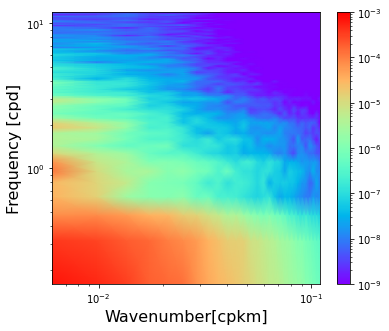

In [54]:
%matplotlib inline
from matplotlib.colors import LogNorm
fig = plt.figure(figsize = (6,5))
ax1 = fig.add_subplot(111)
cs = plt.pcolormesh(kiso, om, (1*Eiso*kiso[None,...]*om[...,None]), shading='gouraud', cmap='rainbow', norm=LogNorm())
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.xlabel(r'Wavenumber[cpkm]', size=16)
plt.ylabel(r'Frequency [cpd]', size = 16)
plt.clim([1e-9, 1e-3])
plt.colorbar()
plt.show()

Now let's try to do this with Hector's code and compare

In [54]:
Theta_reg

<xarray.DataArray (time: 907, xdim: 300, ydim: 376)>
array([[[21.73322105, 21.76150513, 21.76150513, ..., 20.98131752,
         20.93599892, 20.86780548],
        [21.72957039, 21.76980591, 21.76980591, ..., 20.97025299,
         20.91240501, 20.81863594],
        [21.7118969 , 21.7718792 , 21.7718792 , ..., 20.94220734,
         20.8735733 , 20.81535339],
        ...,
        [12.44916153, 12.44613552, 12.44613552, ..., 16.01392937,
         16.0129261 , 15.86713028],
        [12.44434452, 12.44294262, 12.44294262, ..., 16.01722717,
         15.99190807, 15.86645126],
        [12.44943333, 12.43731022, 12.43731022, ..., 16.01092911,
         15.9750433 , 15.90637207]],

       [[21.727005  , 21.75599098, 21.75599098, ..., 20.96472549,
         20.92236137, 20.86410332],
        [21.71998024, 21.76468658, 21.76468658, ..., 20.95125389,
         20.89803696, 20.80978203],
        [21.6908989 , 21.75674438, 21.75674438, ..., 20.91739845,
         20.85222435, 20.79299355],
...
        [17.1232338 , 16.92688751, 16.92688751, ..., 16.25680161,
         16.28533745, 16.23446655],
        [17.02552414, 16.88339615, 16.88339615, ..., 16.14644814,
         16.25514984, 16.23424149],
        [16.9190731 , 16.81090736, 16.81090736, ..., 15.97608757,
         16.17351341, 16.23403931]],

       [[26.12570763, 26.04876709, 26.04876709, ..., 24.36738586,
         24.11274338, 23.8667202 ],
        [26.11052132, 26.02800179, 26.02800179, ..., 24.54089546,
         24.24237061, 24.05321503],
        [26.08800316, 25.97085762, 25.97085762, ..., 24.66322517,
         24.42522621, 24.25525856],
        ...,
        [17.11630058, 16.98860168, 16.98860168, ..., 16.23528099,
         16.27578545, 16.23074341],
        [17.00714874, 16.92383575, 16.92383575, ..., 16.12299538,
         16.24372101, 16.23028374],
        [16.90366936, 16.83286285, 16.83286285, ..., 15.94688225,
         16.15127182, 16.22632027]]])
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 37.67 37.71 37.75
  * xdim     (xdim) float64 0.0 2.221 4.443 6.664 ... 657.5 659.7 661.9 664.2
  * ydim     (ydim) float64 0.0 4.448 8.896 ... 1.659e+03 1.664e+03 1.668e+03

In [26]:
from wf_spectrum import spec_est3
A = Theta_reg.values
d1 = Theta_reg.xdim.diff('xdim').mean().values
d2 = Theta_reg.ydim.diff('ydim').mean().values
d3 = Theta_reg.time.diff('time').mean().values

In [27]:
T_dydxdtime[0:906] # this is the detrended variable to start with
T_1 = T_dydxdtime[0:151]
T_2 = T_dydxdtime[152:302]
T_3 = T_dydxdtime[303:453]
T_4 = T_dydxdtime[454:604]
T_5 = T_dydxdtime[605:755]
T_6 = T_dydxdtime[756:906]

In [126]:
len(np.arange(-1/(2*d1), 1/(2*d1), 1/(T_1.shape[]*d1)))

300

In [130]:
np.swapaxes(np.swapaxes(T_1,0,1),1,2).shape

(300, 376, 151)

In [28]:
T_1_sp,k, l, om = spec_est3(np.swapaxes(np.swapaxes(T_1.values, 0,1),1,2), d1,d2,d3)
T_2_sp,_,_,_ = spec_est3(np.swapaxes(np.swapaxes(T_2.values,0,1),1,2), d1, d2, d3)
T_3_sp,_,_,_ = spec_est3(np.swapaxes(np.swapaxes(T_3.values,0,1),1,2), d1, d2, d3)
T_4_sp,_,_,_ = spec_est3(np.swapaxes(np.swapaxes(T_4.values,0,1),1,2), d1, d2, d3)
T_5_sp,_,_,_ = spec_est3(np.swapaxes(np.swapaxes(T_5.values,0,1),1,2), d1, d2, d3)
T_6_sp,_,_,_ = spec_est3(np.swapaxes(np.swapaxes(T_6.values,0,1),1,2),  d1, d2, d3)

In [29]:
T_mean_sp = (T_1_sp + T_2_sp + T_3_sp + T_4_sp+T_5_sp+T_6_sp) / 6.0

In [143]:
np.arange(0,T_1.shape[0]/2+1)*(1/(T_1.shape[0]*d3))

array([ 0.        ,  0.1589404 ,  0.31788079,  0.47682119,  0.63576159,
        0.79470199,  0.95364238,  1.11258278,  1.27152318,  1.43046358,
        1.58940397,  1.74834437,  1.90728477,  2.06622517,  2.22516556,
        2.38410596,  2.54304636,  2.70198675,  2.86092715,  3.01986755,
        3.17880795,  3.33774834,  3.49668874,  3.65562914,  3.81456954,
        3.97350993,  4.13245033,  4.29139073,  4.45033113,  4.60927152,
        4.76821192,  4.92715232,  5.08609272,  5.24503311,  5.40397351,
        5.56291391,  5.7218543 ,  5.8807947 ,  6.0397351 ,  6.1986755 ,
        6.35761589,  6.51655629,  6.67549669,  6.83443709,  6.99337748,
        7.15231788,  7.31125828,  7.47019868,  7.62913907,  7.78807947,
        7.94701987,  8.10596026,  8.26490066,  8.42384106,  8.58278146,
        8.74172185,  8.90066225,  9.05960265,  9.21854305,  9.37748344,
        9.53642384,  9.69536424,  9.85430464, 10.01324503, 10.17218543,
       10.33112583, 10.49006623, 10.64900662, 10.80794702, 10.96

In [77]:
_,Ei = calc_ispec(k,l,T_mean_sp[:,:,4])
Ei

array([0.01136262, 0.03220155, 0.02851069, 0.0127734 , 0.00869261,
       0.00491209, 0.003941  , 0.00285181, 0.00259916, 0.00266741,
       0.00258088, 0.0025131 , 0.00247933, 0.00257553, 0.00255209,
       0.00261356, 0.00262171, 0.00253361, 0.00239575, 0.00224361,
       0.00206789, 0.00197191, 0.00186811, 0.00185443, 0.00176662,
       0.00168269, 0.00160663, 0.0015731 , 0.00149014, 0.00137655,
       0.00138004, 0.00128882, 0.001233  , 0.00113136, 0.00107724,
       0.00102428, 0.00093276, 0.00091429, 0.00093407, 0.00090329,
       0.00083776, 0.00083912, 0.00080924, 0.00079344, 0.00079666,
       0.00071997, 0.0006937 , 0.00066745, 0.00062227, 0.00065508,
       0.00057432, 0.00053945, 0.0005274 , 0.00051431, 0.00048904,
       0.00045802, 0.0004555 , 0.0004231 , 0.00041255, 0.00041275,
       0.00037929, 0.00036361, 0.00036908])

In [97]:
from spectral_analysis_code import calc_ispec
kiso, Eiso = calc_ispec(k,l,T_mean_sp[:,:,0])
Eiso = np.expand_dims(Eiso, axis=0)
for i in range(1,om.size-1):
    kiso, Ei= calc_ispec(k,l,T_mean_sp[:,:,i])
    Ei = np.expand_dims(Ei,axis=0)
    Eiso = np.concatenate((Eiso, Ei),axis= 0)


In [98]:
Eiso

array([[1.30067414e+00, 1.35189201e+00, 7.61858518e-01, ...,
        9.88731780e-04, 9.10814097e-04, 9.23996939e-04],
       [5.27501463e-01, 6.12125141e-01, 3.65326822e-01, ...,
        1.01685024e-03, 9.24491259e-04, 9.49507868e-04],
       [6.01708371e-02, 1.17155517e-01, 9.66376156e-02, ...,
        8.04589154e-04, 7.56584906e-04, 7.89662327e-04],
       ...,
       [1.59906044e-08, 1.10408860e-07, 2.36131018e-07, ...,
        1.00204572e-07, 9.59102191e-08, 1.00871418e-07],
       [1.74537794e-08, 1.23711564e-07, 2.28587102e-07, ...,
        1.01912265e-07, 9.41124022e-08, 9.82888445e-08],
       [1.76961418e-08, 1.14268193e-07, 2.19714083e-07, ...,
        1.00962079e-07, 9.70988177e-08, 9.79171400e-08]])

In [102]:
Eisop = Eiso[1:,1:]
kisop = kiso[1:]
omp = om[1:-1]

In [76]:
Eiso[:,4]

array([ 2.37151510e-322,  2.31813834e-310,  2.31783446e-310,
        0.00000000e+000,  0.00000000e+000, -4.09546917e+121,
        8.21221440e-131,  5.94954679e-232,  3.11261357e-322,
        2.31783288e-310,  2.31783469e-310,  0.00000000e+000,
        4.63557072e-310,  2.31783439e-310,  2.31832590e-310,
        0.00000000e+000, -2.05620668e+080,  5.18097012e-105,
        0.00000000e+000,  0.00000000e+000,  2.31783468e-310,
        2.31783483e-310,  0.00000000e+000,  9.77476618e-150,
        2.31783226e-310,  0.00000000e+000,  0.00000000e+000,
        4.88635255e+235, -4.37332359e+007,  3.58176404e-081,
        0.00000000e+000,  2.31783467e-310,  2.31783469e-310,
        0.00000000e+000,  2.08355152e-163,  4.63557072e-310,
        2.31783441e-310,  0.00000000e+000, -9.49460772e-298,
        2.25700413e-138,  0.00000000e+000,  0.00000000e+000,
        2.31783468e-310,  2.31783483e-310,  0.00000000e+000,
        1.09929606e-320,  2.31813817e-310,  2.31783446e-310,
        0.00000000e+000,

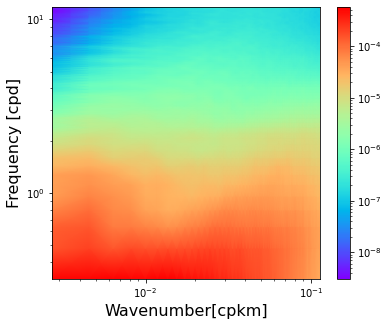

In [103]:
%matplotlib inline
from matplotlib.colors import LogNorm
fig = plt.figure(figsize = (6,5))
ax1 = fig.add_subplot(111)
cs = plt.pcolormesh(kisop, omp, (1*Eisop*kisop[None,...]*omp[...,None]), shading='gouraud', cmap='rainbow', norm=LogNorm())
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.xlabel(r'Wavenumber[cpkm]', size=16)
plt.ylabel(r'Frequency [cpd]', size = 16)
#plt.clim([1e-9, 1e-3])
plt.colorbar()
plt.show()

In [45]:
omp

array([ 0.1589404 ,  0.31788079,  0.47682119,  0.63576159,  0.79470199,
        0.95364238,  1.11258278,  1.27152318,  1.43046358,  1.58940397,
        1.74834437,  1.90728477,  2.06622517,  2.22516556,  2.38410596,
        2.54304636,  2.70198675,  2.86092715,  3.01986755,  3.17880795,
        3.33774834,  3.49668874,  3.65562914,  3.81456954,  3.97350993,
        4.13245033,  4.29139073,  4.45033113,  4.60927152,  4.76821192,
        4.92715232,  5.08609272,  5.24503311,  5.40397351,  5.56291391,
        5.7218543 ,  5.8807947 ,  6.0397351 ,  6.1986755 ,  6.35761589,
        6.51655629,  6.67549669,  6.83443709,  6.99337748,  7.15231788,
        7.31125828,  7.47019868,  7.62913907,  7.78807947,  7.94701987,
        8.10596026,  8.26490066,  8.42384106,  8.58278146,  8.74172185,
        8.90066225,  9.05960265,  9.21854305,  9.37748344,  9.53642384,
        9.69536424,  9.85430464, 10.01324503, 10.17218543, 10.33112583,
       10.49006623, 10.64900662, 10.80794702, 10.96688742, 11.12

In [176]:
Tiso_w_hector.freq_r.values 

array([0.00233191, 0.00533671, 0.00856399, 0.01180948, 0.0151429 ,
       0.01854409, 0.02189005, 0.02518637, 0.02854608, 0.03193667,
       0.03527382, 0.0385899 , 0.04194009, 0.0453129 , 0.04869183,
       0.05201455, 0.05534328, 0.05872514, 0.06209175, 0.06542645,
       0.06875923, 0.07212831, 0.07550198, 0.07884206, 0.08217022,
       0.08553619, 0.08890908, 0.09226712, 0.09562056, 0.09898882,
       0.10235605, 0.10569837, 0.10904349])

In [179]:
Tiso_w_interp_hector = Tiso_w_hector.interp(freq_r = Th_klw_m.freq_r, method = 'cubic')

In [183]:
Tiso_w_interp_hector.omega

<xarray.DataArray 'omega' (omega: 76)>
array([ 0.      ,  0.15894 ,  0.317881,  0.476821,  0.635762,  0.794702,
        0.953642,  1.112583,  1.271523,  1.430464,  1.589404,  1.748344,
        1.907285,  2.066225,  2.225166,  2.384106,  2.543046,  2.701987,
        2.860927,  3.019868,  3.178808,  3.337748,  3.496689,  3.655629,
        3.81457 ,  3.97351 ,  4.13245 ,  4.291391,  4.450331,  4.609272,
        4.768212,  4.927152,  5.086093,  5.245033,  5.403974,  5.562914,
        5.721854,  5.880795,  6.039735,  6.198675,  6.357616,  6.516556,
        6.675497,  6.834437,  6.993377,  7.152318,  7.311258,  7.470199,
        7.629139,  7.788079,  7.94702 ,  8.10596 ,  8.264901,  8.423841,
        8.582781,  8.741722,  8.900662,  9.059603,  9.218543,  9.377483,
        9.536424,  9.695364,  9.854305, 10.013245, 10.172185, 10.331126,
       10.490066, 10.649007, 10.807947, 10.966887, 11.125828, 11.284768,
       11.443709, 11.602649, 11.761589, 11.92053 ])
Coordinates:
  * omega    (omega) float64 0.0 0.1589 0.3179 0.4768 ... 11.44 11.6 11.76 11.92

In [3]:
#I'm going to try to do this with kinetic energy like Brian suggested
U = getMITNCDataSet('/nobackup/amondal/NCData/20211213_spectra_practice/', 'U', 0,0 )
V = getMITNCDataSet('/nobackup/amondal/NCData/20211213_spectra_practice/', 'V', 0,0 ) 

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer


In [3]:
%matplotlib inline
U.U[0]

<xarray.DataArray 'U' (lat: 300, lon: 600)>
dask.array<getitem, shape=(300, 600), dtype=float64, chunksize=(300, 600), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -64.0 -63.96 -63.92 -63.88 ... -40.12 -40.08 -40.04

In [37]:
U.U

<xarray.DataArray 'U' (time: 2208, lat: 300, lon: 600)>
dask.array<concatenate, shape=(2208, 300, 600), dtype=float64, chunksize=(1, 300, 600), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -64.0 -63.96 -63.92 -63.88 ... -40.12 -40.08 -40.04
Dimensions without coordinates: time

In [4]:
E = (U.U**2 + V.V**2)*0.5 #Kinetic energy density

In [5]:
oldtime = E.time
oldtime
newtime = oldtime * 1/24.0 # hours * 1day/24hrs

In [6]:
oldlat = E.lat
oldlatmean = np.mean(oldlat)
newlattokm = oldlat  * 110.574 #deg * km/deg

In [7]:
oldlon = E.lon
oldlonmean = np.mean(oldlon)
newlontokm = oldlon * 111.320 * np.cos(oldlatmean) #deg * km/deg

In [8]:
%time En = xr.DataArray(E.values, dims=['time','lat','lon'], coords=[newtime,newlattokm,newlontokm])

CPU times: user 23.7 s, sys: 17.3 s, total: 41.1 s
Wall time: 43.4 s


In [9]:
En

<xarray.DataArray (time: 2208, lat: 300, lon: 600)>
array([[[0.01827522, 0.01827522, 0.02032629, ..., 0.01359435,
         0.01194377, 0.01045383],
        [0.02187567, 0.02187567, 0.02004344, ..., 0.01528519,
         0.01375392, 0.01279825],
        [0.02374021, 0.02374021, 0.0213127 , ..., 0.02032932,
         0.01671998, 0.01436583],
        ...,
        [0.06505886, 0.06505886, 0.0620556 , ..., 0.01682821,
         0.01243733, 0.01327256],
        [0.09336032, 0.09336032, 0.06948365, ..., 0.02318682,
         0.01712659, 0.01634605],
        [0.09670779, 0.09670779, 0.06419578, ..., 0.02757033,
         0.02096888, 0.01903731]],

       [[0.01855085, 0.01855085, 0.01902205, ..., 0.01345954,
         0.01218708, 0.0127434 ],
        [0.02054317, 0.02054317, 0.01815867, ..., 0.01223157,
         0.01094002, 0.01154496],
        [0.02131748, 0.02131748, 0.0178162 , ..., 0.01463007,
         0.01162493, 0.01073349],
...
        [0.06257947, 0.06257947, 0.09625895, ..., 0.03055386,
         0.0153176 , 0.00548579],
        [0.08322392, 0.08322392, 0.12771341, ..., 0.03928393,
         0.01911311, 0.00658325],
        [0.09846819, 0.09846819, 0.14308694, ..., 0.04313076,
         0.02149004, 0.00855386]],

       [[0.1004077 , 0.1004077 , 0.10153761, ..., 0.01262444,
         0.01436706, 0.01583568],
        [0.0915987 , 0.0915987 , 0.08994921, ..., 0.01966657,
         0.020814  , 0.02296601],
        [0.07551433, 0.07551433, 0.07588053, ..., 0.02376634,
         0.02021071, 0.02039879],
        ...,
        [0.08594444, 0.08594444, 0.10702376, ..., 0.03426046,
         0.0160861 , 0.0034752 ],
        [0.09929368, 0.09929368, 0.12216396, ..., 0.04075756,
         0.0207441 , 0.0058511 ],
        [0.11312386, 0.11312386, 0.13830143, ..., 0.0405428 ,
         0.02078486, 0.00805589]]])
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 91.88 91.92 91.96
  * lat      (lat) float64 3.317e+03 3.322e+03 3.326e+03 ... 4.635e+03 4.64e+03
  * lon      (lon) float64 1.053e+03 1.052e+03 1.051e+03 ... 660.0 659.3 658.7

So there is a way to do parallelized Bartlet's method with xrft. Welch's method is Bartlett's just with overlapping chunks. I can achieve bartlett's Welch's method by padding the original xaray with part of itself so that the "overlapped chunks" become part of the original xarray. 

In [47]:
En_klom = xrft.xrft.fft(En, dim = ['lat','lon'], real_dim = 'lon', detrend='linear', window='tukey', window_correction=True,truncate=True, true_amplitude = True)
#En_kl = xrft.xrft.fft(En_k, dim = 'lon', real_dim = 'lon', detrend='linear', window='tukey', window_correction=True,truncate=True, true_amplitude = True)

In [36]:
En_kl

<xarray.DataArray (time: 2208, freq_lat: 151, freq_lon: 301)>
array([[[-1.93943898e+02+0.00000000e+00j,
          2.41266046e+02+2.88161691e+02j,
         -2.03374757e+02-6.11357623e+02j, ...,
          1.28586706e+00+4.99725653e-01j,
         -1.25632033e-01-1.79141209e+00j,
         -1.41582301e+00+0.00000000e+00j],
        [-2.23226885e+02+0.00000000e+00j,
          1.42678101e+02+5.10021184e+02j,
          3.18340929e+02+4.82680901e+02j, ...,
         -2.14699645e+00+1.13223034e+00j,
          5.61499461e-01+1.40634840e+00j,
          2.10115655e+00+0.00000000e+00j],
        [ 1.72379596e+02+0.00000000e+00j,
          7.86463303e+01-9.05693152e+02j,
         -5.80713072e+02+2.62616789e+02j, ...,
          2.15195234e+00-3.42573789e+00j,
         -3.72042286e-01-5.74341502e-01j,
         -1.99667093e+00+0.00000000e+00j],
        ...,
        [-1.52871919e+00+0.00000000e+00j,
...
          4.21214795e-02+0.00000000e+00j],
        ...,
        [ 2.56589649e+00+0.00000000e+00j,
          6.73027802e+00+1.71261291e+00j,
         -9.23505631e+00-1.80446272e-01j, ...,
         -9.28497680e-01-5.17703796e-01j,
          1.94387930e-01+2.71137307e-01j,
         -1.61334820e-01+0.00000000e+00j],
        [ 4.33961323e+00+0.00000000e+00j,
         -1.53881853e+01-5.13438844e+00j,
          1.36418007e+01+3.41524418e+00j, ...,
         -5.91274652e-02-4.95973940e-01j,
         -5.27815537e-02+3.61188943e-01j,
          9.49548375e-02+0.00000000e+00j],
        [-1.46647127e+01+0.00000000e+00j,
          1.77551225e+01+6.49029374e+00j,
         -8.76161472e+00-4.61419803e-01j, ...,
          5.84317104e-01+8.13379070e-01j,
          2.01090871e-01-2.25053616e-01j,
         -5.38856030e-01+0.00000000e+00j]]])
Coordinates:
  * time      (time) float64 0.0 0.04167 0.08333 0.125 ... 91.88 91.92 91.96
  * freq_lat  (freq_lat) float64 0.0 0.0007536 0.001507 ... 0.1115 0.1123 0.113
  * freq_lon  (freq_lon) float64 0.0 0.002533 0.005066 ... 0.7548 0.7573 0.7599

In [37]:
from spectral_analysis_code import *
En_K = isotropize(En_kl, ['freq_lat', 'freq_lon'], 'time')

In [38]:
En_K

<xarray.DataArray (time: 2208, kr: 44)>
array([[ 0.48923388, -0.45949792,  0.25237238, ..., -0.06557092,
        -0.09269021, -0.14418992],
       [ 0.45566132, -0.35409402,  0.27700606, ..., -0.02785391,
        -0.10851911, -0.17756242],
       [ 0.41294257, -0.32209494,  0.25320141, ..., -0.01307681,
        -0.08635909, -0.23447938],
       ...,
       [-1.10120175, -0.28511761,  0.86624219, ...,  0.00307165,
        -0.08304578,  0.04036864],
       [-1.12155372, -0.33270289,  0.94229061, ...,  0.02120655,
        -0.0780439 ,  0.08345256],
       [-1.10926016, -0.43250866,  0.97290163, ...,  0.05108641,
        -0.06645867,  0.08757269]])
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 91.88 91.92 91.96
  * kr       (kr) float64 0.001321 0.003964 0.006607 ... 0.1097 0.1123 0.115

In [39]:
#Now, to try Bartlett's method
n = En_K.time.size
En_Kom = xrft.xrft.power_spectrum(En_K.chunk({'time':int(n/4)}), dim=['time'], chunks_to_segments=True, real_dim = 'time', detrend='linear', window='tukey', window_correction=True,truncate=True, true_amplitude = True)

In [40]:
En_Kom_dom = En_Kom / En_Kom['freq_time'].spacing
# So that was pain free but you need to figure out how to make time register in cpd instead of 
#cph like it seems to want to 

In [41]:
En_Kom_bar = En_Kom_dom.mean('time_segment').compute()

In [42]:
En_Kom_bar

<xarray.DataArray (freq_time: 277, kr: 44)>
array([[5.61027285e-01, 5.04754530e+00, 4.21436421e+00, ...,
        7.61895305e-02, 1.58258474e-02, 2.20320831e-02],
       [8.21500598e+00, 2.22404721e+01, 3.91749254e+01, ...,
        5.54624778e-01, 1.55995547e-01, 6.53794740e-01],
       [3.68310651e+00, 8.77687026e+00, 2.10981210e+01, ...,
        5.96792881e-01, 1.30682382e-01, 5.43302535e-01],
       ...,
       [8.86999219e-06, 1.99803885e-05, 9.31874994e-05, ...,
        2.96238994e-05, 2.27248179e-05, 2.03295613e-05],
       [7.07139558e-06, 3.08254981e-05, 8.14431477e-05, ...,
        2.34239573e-05, 1.41330186e-05, 2.39663912e-05],
       [2.59831659e-06, 1.85037732e-05, 1.22999084e-04, ...,
        1.82202835e-05, 9.82377569e-06, 1.19441855e-05]])
Coordinates:
  * kr         (kr) float64 0.001321 0.003964 0.006607 ... 0.1097 0.1123 0.115
  * freq_time  (freq_time) float64 0.0 0.04348 0.08696 ... 11.91 11.96 12.0

In [43]:
# variance preserving form
En_Kom_bar_vp = En_Kom_bar * En_Kom_bar.kr * En_Kom_bar.freq_time

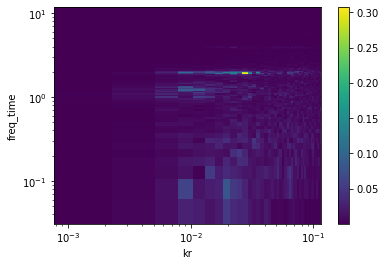

In [45]:
%matplotlib inline
En_Kom_bar_vp[1:-1].plot(xscale = 'log', yscale = 'log')